In [3]:
import pandas as pd
data = pd.read_csv("../dataset/AEP_hourly.csv")
data['Datetime'] = pd.to_datetime(data['Datetime'])

# Ordenar por la columna 'Fecha' en orden ascendente
df_sorted = data.sort_values(by='Datetime', ascending=True, ignore_index=True)
df_sorted.to_csv("../dataset/AEP_hourly.csv", index=False)

{'Datetime': '2018-08-03 00:00:00', 'Year': 2018, 'Month': 8, 'Day': 3, 'WeekOfYear': 31, 'DayOfWeek': 4, 'DayOfYear': 215, 'Weekend': 0, 'Quarter': 3, 'Hour': 0, 'LastDay': 15964.0}
RMSE: 427.653967


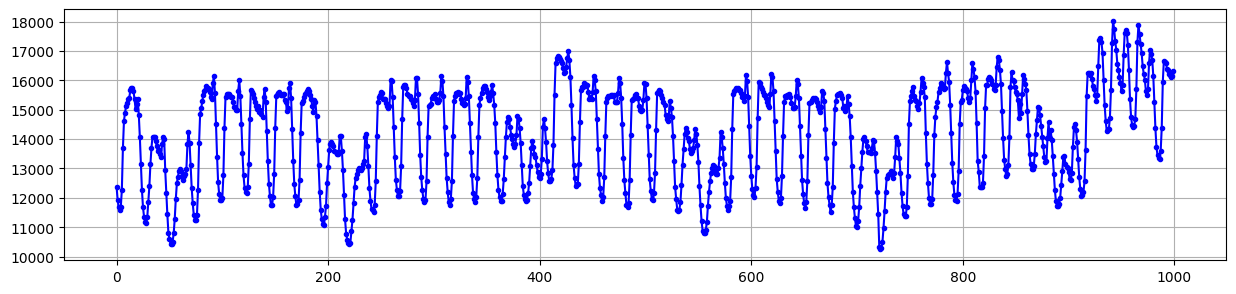

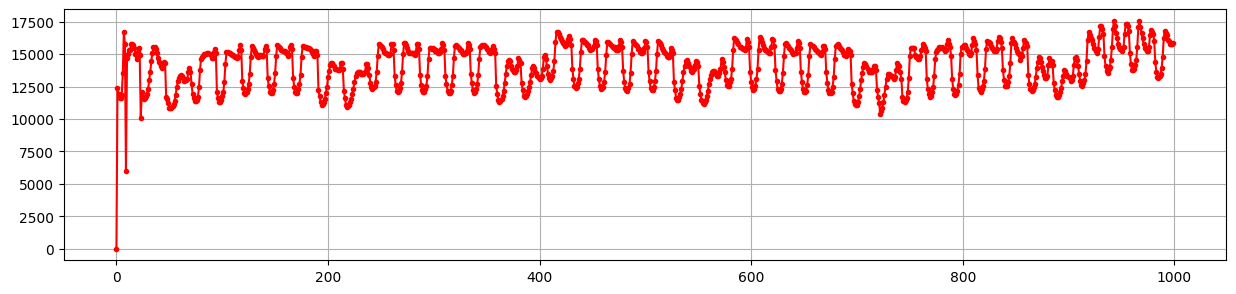

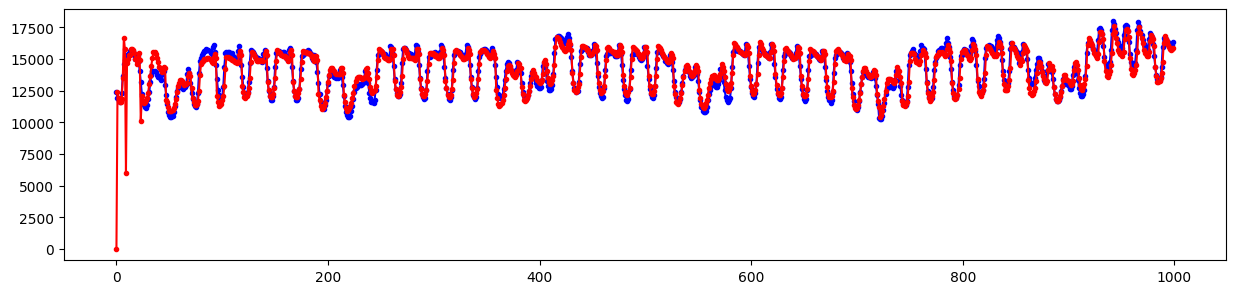

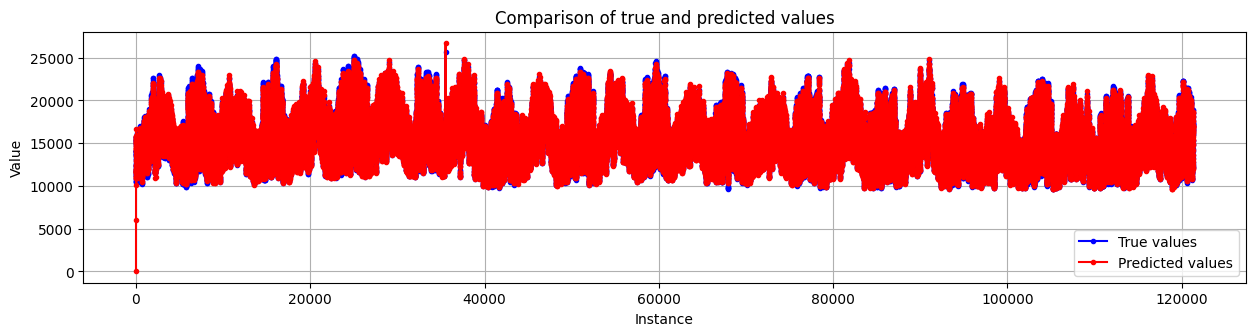

In [15]:
from river import stream, compose, preprocessing, evaluate, metrics, linear_model, utils, stats, feature_extraction
from river.tree import HoeffdingTreeClassifier
import datetime
import matplotlib.pyplot as plt

dataset_path = "../dataset/AEP_hourly.csv"

def float_converter(a):
    try:
        a=float(a)
    except ValueError:
        a=None
    return a

past_metrics = {"LastDay": 0}

def divide_date(x):#feature enginnering
    try:
        dt = datetime.datetime.strptime(x['Datetime'], "%Y-%m-%d %H:%M:%S")
        x["Year"]=dt.year
        x["Month"]=dt.month
        x["Day"]=dt.day
        x["WeekOfYear"]=dt.isocalendar().week
        x["DayOfWeek"]=dt.weekday()
        x["DayOfYear"]=dt.timetuple().tm_yday
        x["Weekend"]= int(dt.weekday() >= 5)
        x["Quarter"]=int((dt.month - 1) // 3 + 1)
        x["Hour"]=dt.hour
        x["LastDay"]=past_metrics["LastDay"]
    except:
        x["Year"] = None
        x["Month"] = None
        x["Day"] = None
        x["WeekOfYear"] = None
        x["DayOfWeek"] = None
        x["DayOfYear"] = None
        x["Weekend"] = None
        x["Quarter"] = None
        x["Hour"] = None
        x["LastDay"] = None
    return x

energy_consumption = stream.iter_csv(dataset_path, target="AEP_MW", drop_nones=True, converters={'AEP_MW':float_converter})

model = compose.Pipeline(
    ('features', compose.TransformerUnion(
        ('date_features', compose.FuncTransformer(divide_date)),
        ('last_7_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),7),target_name="last_7_mean")),
        ('last_14_mean', feature_extraction.TargetAgg(by=None, how=utils.Rolling(stats.Mean(),14), target_name="last_14_mean"))
    )),
    ('drop_non_features', compose.Discard('Datetime')),
    ('lin_reg', linear_model.BayesianLinearRegression())
)

metric = metrics.RMSE()
y_trues = []
y_preds = []
for x, y in energy_consumption:
    y_pred = model.predict_one(x)
    model.learn_one(x, y)
    metric.update(y, y_pred)
    past_metrics["LastDay"] = y
    y_trues.append(y)
    y_preds.append(y_pred)

print(x)
print(metric)

plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
plt.plot(y_trues[:1000], marker='.', linestyle='-', color='b', label='True values')
plt.grid(True)

plt.figure(figsize=(15,15))
plt.subplot(4,1,2)
plt.plot(y_preds[:1000], marker='.', linestyle='-', color='r', label='Predicted values')
plt.grid(True)

plt.figure(figsize=(15,15))
plt.subplot(4,1,3)
plt.plot(y_trues[:1000], marker='.', linestyle='-', color='b', label='True values')
plt.plot(y_preds[:1000], marker='.', linestyle='-', color='r', label='Predicted values')

plt.figure(figsize=(15,15))
plt.subplot(4,1,4)
plt.plot(y_trues, marker='.', linestyle='-', color='b', label='True values')
plt.plot(y_preds, marker='.', linestyle='-', color='r', label='Predicted values')

# Personalización
plt.title('Comparison of true and predicted values')
plt.xlabel('Instance')
plt.ylabel('Value')
plt.grid(True)
plt.legend()

# Mostrar la gráfica
plt.show()
                            